In [1]:
import logging

import joblib
import numpy as np
import pandas as pd

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data():
    path = "/Users/edeno/Downloads/"
    animal_date_epoch = "j1620210710_02_r1"
    position_info = pd.read_pickle(path + f"{animal_date_epoch}_position_info.pkl")
    spike_times = joblib.load(path + f"{animal_date_epoch}_HPC_spike_times.pkl")
    track_graph = joblib.load(path + f"{animal_date_epoch}_track_graph.pkl")
    linear_edge_order = joblib.load(path + f"{animal_date_epoch}_linear_edge_order.pkl")
    linear_edge_spacing = joblib.load(
        path + f"{animal_date_epoch}_linear_edge_spacing.pkl"
    )

    return (
        position_info,
        spike_times,
        track_graph,
        linear_edge_order,
        linear_edge_spacing,
    )


position_info, spike_times, track_graph, edge_order, edge_spacing = load_data()
edge_spacing = 1.5
time = position_info.index
position = position_info["linear_position"].to_numpy()

/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/non_local_detector/likelihoods/clusterless_kde.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Discrete transition: [[0.968 0.016 0.016]
 [0.005 0.99  0.005]
 [0.016 0.016 0.968]]


01-Apr-25 20:07:04 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
01-Apr-25 20:07:04 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/jaxlib/../../../libtpu.so' (no such file), '/Users/edeno/miniconda3/envs/non_local_detector2/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Iter: 0, Marginal Likelihood: -3673408.5
Discrete transition: [[0.98340396 0.01322991 0.00336613]
 [0.005      0.99       0.005     ]
 [0.46913288 0.18410727 0.34675985]]
Iter: 1, Marginal Likelihood: -3664278.25
Discrete transition: [[0.98198087 0.01265391 0.00536523]
 [0.005      0.99       0.005     ]
 [0.63477927 0.17105476 0.19416597]]
Iter: 2, Marginal Likelihood: -3651991.75
Discrete transition: [[0.97880483 0.0127286  0.00846656]
 [0.005      0.99       0.005     ]
 [0.68418074 0.15380839 0.16201086]]
Iter: 3, Marginal Likelihood: -3648892.0
Discrete transition: [[0.97609001 0.01272137 0.01118863]
 [0.005      0.99       0.005     ]
 [0.72659673 0.13231738 0.14108588]]
Iter: 4, Marginal Likelihood: -3648847.75


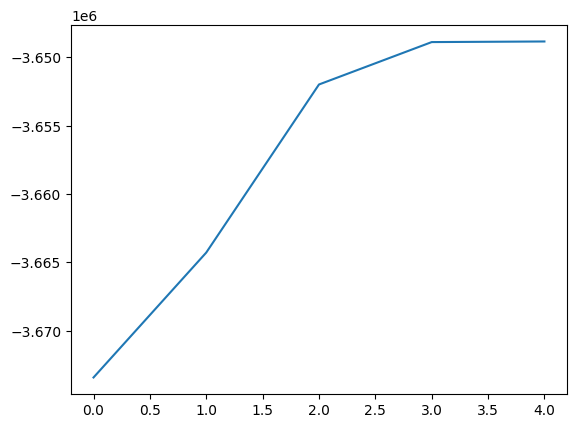

In [2]:
import jax.numpy as jnp
import jax.scipy.stats
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from non_local_detector.continuous_state_transitions import (
    RandomWalk,
)
from non_local_detector.core import (
    check_converged,
    chunked_filter_smoother,
)
from non_local_detector.discrete_state_transitions import (
    _estimate_discrete_transition,
)
from non_local_detector.environment import Environment
from non_local_detector.likelihoods.common import get_spikecount_per_time_bin

EPS = 1e-15


def estimate_place_fields_kde(
    spike_counts, position_index, env, kde_var=np.sqrt(12.5), weights=None
):

    if weights is None:
        weights = np.ones_like(position_index)

    place_bin_center_ind_to_node = np.asarray(env.place_bin_centers_nodes_df_.node_id)
    n_place_bins = env.place_bin_centers_.size
    gaussian_dist = np.zeros((n_place_bins, n_place_bins))
    gaussian = multivariate_normal(mean=0.0, cov=kde_var)

    for bin_ind1, node1 in enumerate(place_bin_center_ind_to_node):
        for bin_ind2, node2 in enumerate(place_bin_center_ind_to_node):
            try:
                gaussian_dist[bin_ind1, bin_ind2] = gaussian.pdf(
                    env.distance_between_nodes_[node1][node2]
                )
            except KeyError:
                # bins not on track interior will be -1 and not in distance
                # between nodes
                gaussian_dist[bin_ind1, bin_ind2] = EPS

    gaussian_dist = gaussian_dist[:, position_index]
    # gaussian_dist /= gaussian_dist.sum(axis=1, keepdims=True)
    gaussian_dist *= weights

    weighted_occupancy = np.sum(gaussian_dist, axis=1) + EPS
    return np.stack(
        [
            (gaussian_dist @ neuron_count) / weighted_occupancy
            for neuron_count in spike_counts.T
        ],
        axis=1,
    )


def estimate_place_fields(
    spike_counts, position_index, occupancy_count, weights=None, sampling_frequency=500
):
    if weights is None:
        weights = np.ones_like(position_index)
    estimated_place_fields = []
    n_position_bins = occupancy_count.shape[0]

    for count in spike_counts.T:
        # neuron_count = np.bincount(
        #     position_index[count > 0],
        #     minlength=n_position_bins,
        #     weights=weights[count > 0],
        # )
        neuron_count = np.bincount(
            position_index, minlength=n_position_bins, weights=weights * count
        )
        estimated_place_fields.append(
            np.where(
                occupancy_count == 0,
                EPS,
                (neuron_count + EPS) / (occupancy_count + EPS),
            ),
        )

    return jnp.clip(
        np.stack(estimated_place_fields, axis=1),
        a_min=EPS,
        a_max=125 / sampling_frequency,
    )


def estimate_log_likelihood(
    spike_counts,
    position_index,
    occupancy_count,
    env,
    weights=None,
    no_spike_rate=1e-10,
):

    n_time, n_position_bins = spike_counts.shape[0], occupancy_count.shape[0]
    # estimated_position_rates = estimate_place_fields(
    #     spike_counts, position_index, occupancy_count, weights
    # )
    estimated_position_rates = estimate_place_fields_kde(
        spike_counts, position_index, env, kde_var=np.sqrt(12.5), weights=weights
    )

    local_log_likelihood = jnp.sum(
        jax.scipy.stats.poisson.logpmf(
            spike_counts, estimated_position_rates[position_index]
        ),
        axis=1,
    )
    no_spike_log_likelihood = jnp.sum(
        jax.scipy.stats.poisson.logpmf(
            spike_counts, jnp.ones_like(spike_counts) * no_spike_rate
        ),
        axis=1,
    )
    non_local_log_likelihood = jnp.zeros((n_time, n_position_bins))
    for count, rate in zip(spike_counts.T, estimated_position_rates.T, strict=False):
        non_local_log_likelihood += jax.scipy.stats.poisson.logpmf(
            np.expand_dims(count, axis=1),
            jnp.expand_dims(rate, axis=0),
        )

    log_likelihood = jnp.concatenate(
        [
            local_log_likelihood[:, None],
            no_spike_log_likelihood[:, None],
            non_local_log_likelihood,
        ],
        axis=1,
    )

    return log_likelihood, estimated_position_rates


def run_EM(
    time,
    position,
    spike_times,
    weights,
    track_graph,
    edge_order,
    edge_spacing,
    place_bin_size=2.0,
    max_iter=30,
    estimate_initial_conditions=False,
    estimate_discrete_transition=False,
    estimate_local_place_fields=False,
):
    spike_counts = np.stack(
        [get_spikecount_per_time_bin(times, time) for times in spike_times], axis=1
    )

    env = Environment(
        place_bin_size=place_bin_size,
        track_graph=track_graph,
        edge_order=edge_order,
        edge_spacing=edge_spacing,
    ).fit_place_grid(position[:, None])
    n_position_bins = env.place_bin_centers_.shape[0]
    position_index = np.digitize(position, env.place_bin_edges_[:, 0][1:-1])
    occupancy_count = np.bincount(
        position_index, minlength=n_position_bins, weights=weights
    )

    initial_conditions = np.zeros((n_position_bins + 2,))

    # State 1 is local - start in local state
    # initial_conditions[1:] are the non-local state initial conditions
    initial_conditions[0] = 1.0

    # Local -> Local, Local -> Non-Local, Non-Local -> Local, Non-Local -> Non-Local
    prob_local = 0.968
    prob_non_local = 0.968
    no_spike_prob = 0.99
    discrete_transition_matrix = np.array(
        [
            [prob_local, (1 - prob_local) / 2, (1 - prob_local) / 2],
            [(1 - no_spike_prob) / 2, no_spike_prob, (1 - no_spike_prob) / 2],
            [(1 - prob_non_local) / 2, (1 - prob_non_local) / 2, prob_non_local],
        ]
    )
    discrete_transition_matrix = discrete_transition_matrix / np.sum(
        discrete_transition_matrix, axis=1, keepdims=True
    )

    continuous_transition_matrix = np.zeros((n_position_bins + 2, n_position_bins + 2))
    # Local -> Local
    continuous_transition_matrix[0, 0] = 1.0
    # Local -> No-Spike
    continuous_transition_matrix[0, 1] = 1.0
    # Local -> Non-Local
    continuous_transition_matrix[0, 2:] = np.ones((n_position_bins,)) / n_position_bins

    # No-Spike -> Local
    continuous_transition_matrix[1, 0] = 1.0
    # No-Spike -> No-Spike
    continuous_transition_matrix[1, 1] = 1.0
    # No-Spike -> Non-Local
    continuous_transition_matrix[1, 2:] = np.ones((n_position_bins,)) / n_position_bins

    # Non-Local -> Local, consider random walk centered around the current position
    continuous_transition_matrix[2:, 0] = np.ones((n_position_bins,)) / n_position_bins
    # Non-Local -> No-Spike
    continuous_transition_matrix[2:, 1] = np.ones((n_position_bins,)) / n_position_bins
    # Non-Local -> Non-Local
    continuous_transition_matrix[2:, 2:] = RandomWalk(
        movement_var=6.0
        # movement_var=0.71
    ).make_state_transition(environments=[env])

    continuous_transition_matrix = continuous_transition_matrix / np.sum(
        continuous_transition_matrix, axis=1, keepdims=True
    )  # Normalize

    # State 0 is Local
    # State 1 is No-Spike
    # State 2 is Non-Local
    state_ind = np.zeros((n_position_bins + 2,), dtype=int)
    state_ind[1] = 1
    state_ind[2:] = 2

    # Combine the continuous and discrete transition matrices

    print(f"Discrete transition: {discrete_transition_matrix}")
    transition_matrix = (
        continuous_transition_matrix
        * discrete_transition_matrix[np.ix_(state_ind, state_ind)]
    )
    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

    # Initial conditions
    weights = np.ones_like(time)
    marginal_likelihoods = []
    is_converged = False
    iter = 0

    position_rates_iter = []
    local_prob_iter = []

    while not is_converged and iter < max_iter:
        log_likelihood, estimated_position_rates = estimate_log_likelihood(
            spike_counts, position_index, occupancy_count, env, weights
        )
        position_rates_iter.append(estimated_position_rates)

        (
            acausal_posterior,
            acausal_state_probabilities,
            marginal_likelihood,
            causal_state_probabilities,
            predictive_state_probabilities,
            _,
        ) = chunked_filter_smoother(
            time,
            state_ind,
            initial_conditions,
            transition_matrix,
            None,
            None,
            cache_log_likelihoods=False,
            log_likelihoods=log_likelihood,
        )
        local_prob_iter.append(causal_state_probabilities[:, 0])
        marginal_likelihoods.append(marginal_likelihood)

        try:
            is_converged, _ = check_converged(
                marginal_likelihoods[-1], marginal_likelihoods[-2]
            )
        except IndexError:
            pass

        print(f"Iter: {iter}, Marginal Likelihood: {marginal_likelihoods[-1]}")
        if is_converged:
            break

        iter += 1

        if estimate_local_place_fields:
            weights = np.maximum(acausal_state_probabilities[:, 0], EPS)
        if estimate_initial_conditions:
            initial_conditions = acausal_posterior[0]
        if estimate_discrete_transition:
            (
                discrete_transition_matrix,
                _,
            ) = _estimate_discrete_transition(
                causal_state_probabilities,
                predictive_state_probabilities,
                acausal_state_probabilities,
                discrete_transition_matrix,
                discrete_transition_coefficients=None,
                discrete_transition_design_matrix=None,
                transition_concentration=10.0,
                transition_stickiness=np.array([141.25, 0.0, 141.25]),
                transition_regularization=1e-10,
            )
            # Don't update the no-spiking state
            discrete_transition_matrix[1, :] = [
                (1 - no_spike_prob) / 2,
                no_spike_prob,
                (1 - no_spike_prob) / 2,
            ]
            print(f"Discrete transition: {discrete_transition_matrix}")

            transition_matrix = (
                continuous_transition_matrix
                * discrete_transition_matrix[np.ix_(state_ind, state_ind)]
            )
            transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

    return (
        initial_conditions,
        continuous_transition_matrix,
        discrete_transition_matrix,
        state_ind,
        env,
        estimated_position_rates,
        log_likelihood,
        acausal_posterior,
        acausal_state_probabilities,
        marginal_likelihoods,
        is_converged,
        position_rates_iter,
        local_prob_iter,
    )


weights = np.ones_like(time)
(
    initial_conditions,
    continuous_transition_matrix,
    discrete_transition_matrix,
    state_ind,
    env,
    estimated_position_rates,
    log_likelihood,
    acausal_posterior,
    acausal_state_probabilities,
    marginal_likelihoods,
    is_converged,
    position_rates_iter,
    local_prob_iter,
) = run_EM(
    time,
    position,
    spike_times,
    weights,
    track_graph,
    edge_order,
    edge_spacing,
    max_iter=10,
    place_bin_size=1.5,
    estimate_initial_conditions=True,
    estimate_discrete_transition=True,
    estimate_local_place_fields=True,
)

plt.figure()
plt.plot(marginal_likelihoods)

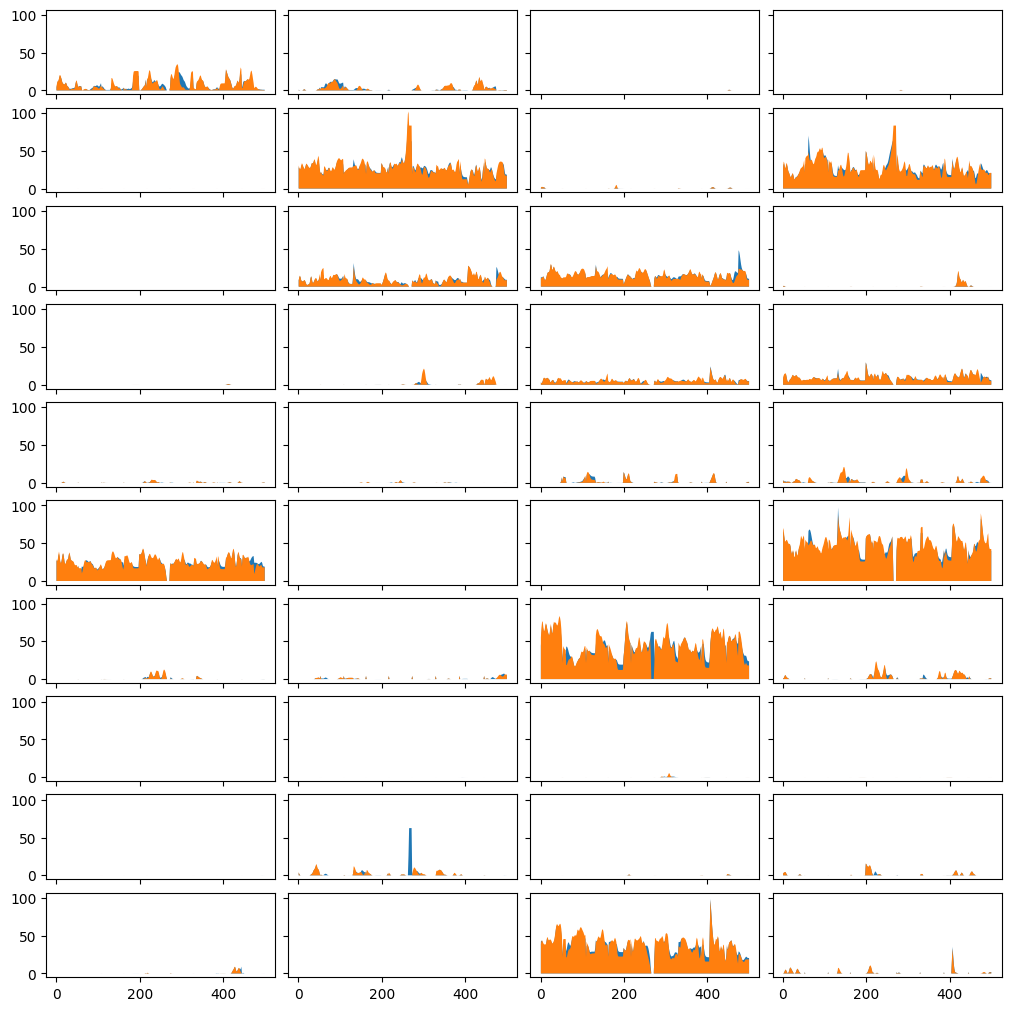

In [3]:
fig, axes = plt.subplots(
    10, 4, figsize=(10, 10), sharex=True, sharey=True, constrained_layout=True
)

for neuron_ind, ax in enumerate(axes.flat):
    ax.fill_between(
        env.place_bin_centers_.squeeze(),
        position_rates_iter[0][:, neuron_ind] * 500,
    )
    ax.fill_between(
        env.place_bin_centers_.squeeze(),
        position_rates_iter[-1][:, neuron_ind] * 500,
    )

(0.0, 10.0)

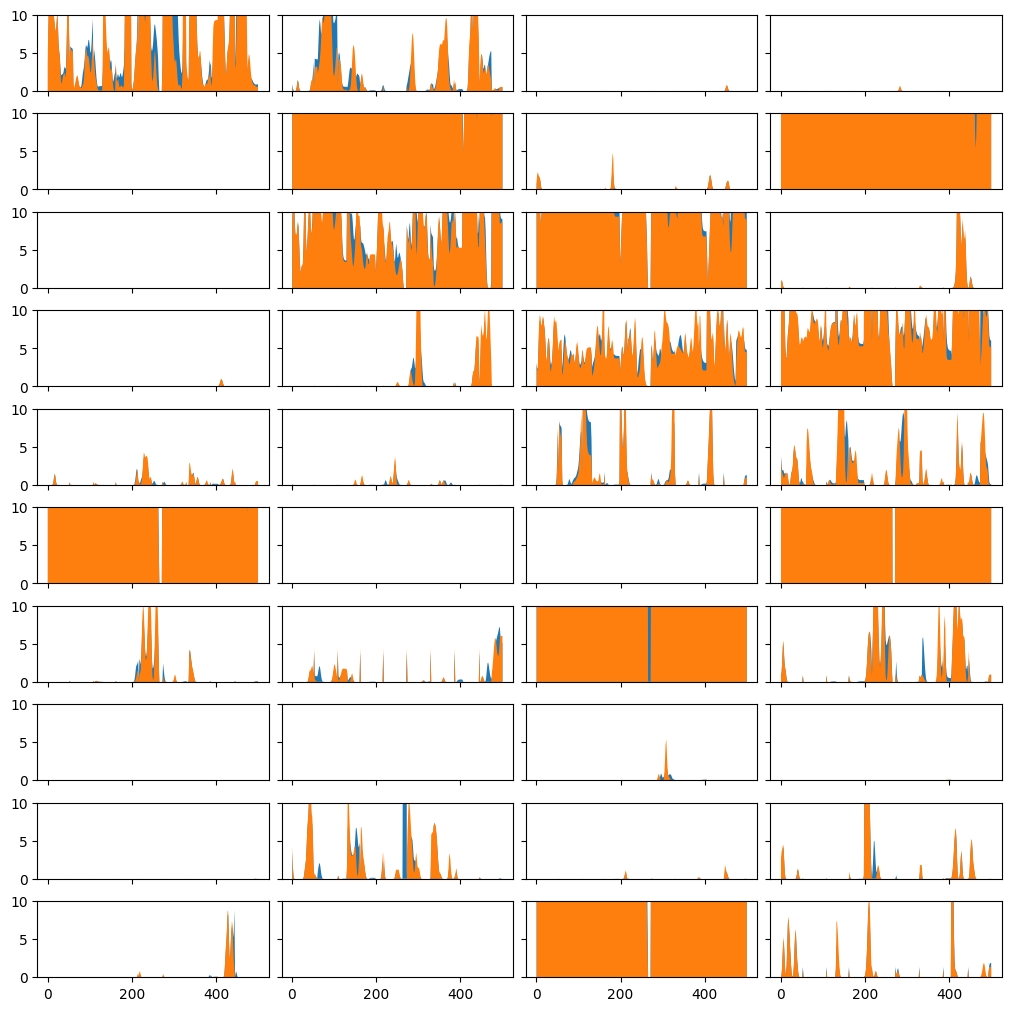

In [5]:
fig, axes = plt.subplots(
    10, 4, figsize=(10, 10), sharex=True, sharey=True, constrained_layout=True
)

for neuron_ind, ax in enumerate(axes.flat):
    ax.fill_between(
        env.place_bin_centers_.squeeze(),
        position_rates_iter[0][:, neuron_ind] * 500,
    )
    ax.fill_between(
        env.place_bin_centers_.squeeze(),
        position_rates_iter[-1][:, neuron_ind] * 500,
    )
plt.ylim((0, 10))

In [4]:
discrete_transition_matrix

array([[0.97614678, 0.01269557, 0.01115765],
       [0.005     , 0.99      , 0.005     ],
       [0.7267347 , 0.13269239, 0.14057291]])

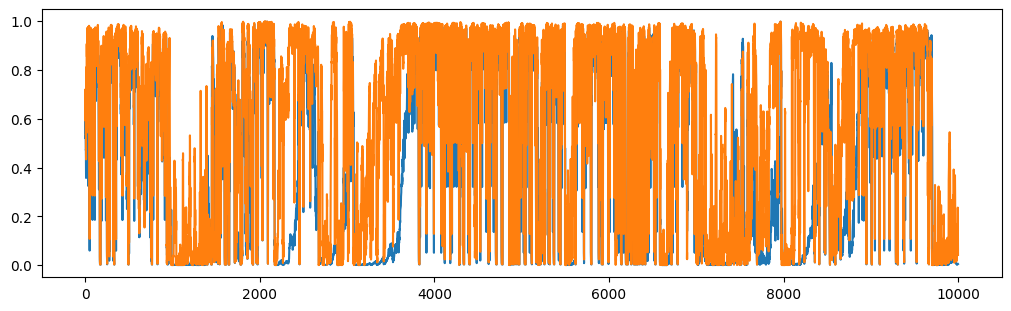

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True)
ax.plot(local_prob_iter[0][100_000:110_000])
ax.plot(local_prob_iter[-1][100_000:110_000])

In [6]:
from non_local_detector.model_checking.posterior_consistency import (
    posterior_consistency_hpd_overlap,
    posterior_consistency_kl_divergence,
)

kl_div = posterior_consistency_kl_divergence(
    posterior=acausal_posterior, likelihood=np.exp(log_likelihood)
)
hpd_overlap = posterior_consistency_hpd_overlap(
    posterior=acausal_posterior, likelihood=np.exp(log_likelihood)
)

(1625935781.7008803, 1625935782.2008803)

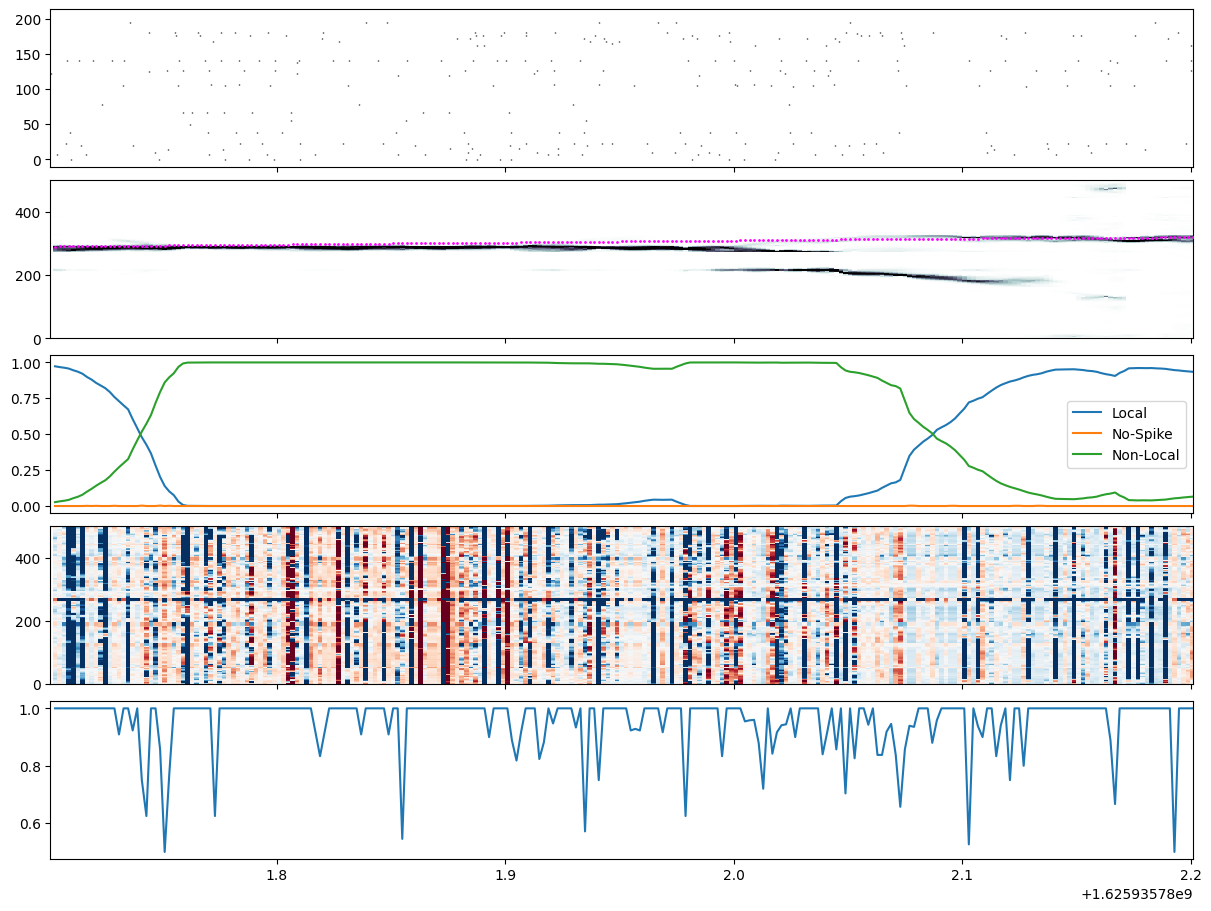

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(12, 9), sharex=True, constrained_layout=True)


time_slice = slice(time[0] + 24.0, time[0] + 24.5)
is_time_slice = (time >= time_slice.start) & (time <= time_slice.stop)

t, x = np.meshgrid(time[is_time_slice], env.place_bin_centers_)
conditional_non_local_acausal_posterior = acausal_posterior[is_time_slice, 2:]
conditional_non_local_acausal_posterior /= np.nansum(
    conditional_non_local_acausal_posterior, axis=1
)[:, np.newaxis]

axes[0].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times >= time_slice.start)
            & (neuron_spike_times <= time_slice.stop)
        ]
        for neuron_spike_times in spike_times
    ],
    colors="k",
    linewidths=1,
    rasterized=True,
)
axes[1].pcolormesh(
    t,
    x,
    conditional_non_local_acausal_posterior.T,
    vmin=0.0,
    vmax=0.1,
    rasterized=True,
    cmap="bone_r",
)
axes[1].scatter(
    time[is_time_slice],
    position[is_time_slice],
    s=1,
    color="magenta",
    rasterized=True,
    zorder=10,
)
axes[2].plot(
    time[is_time_slice], acausal_state_probabilities[is_time_slice, 0], label="Local"
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities[is_time_slice, 1],
    label="No-Spike",
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities[is_time_slice, 2],
    label="Non-Local",
)
axes[2].legend()


axes[3].pcolormesh(
    t,
    x,
    (
        log_likelihood[is_time_slice, 2:]
        - log_likelihood[is_time_slice, 0][:, np.newaxis]
    ).T,
    cmap="RdBu_r",
    rasterized=True,
    vmin=-3,
    vmax=3,
)
axes[4].plot(time[is_time_slice], hpd_overlap[is_time_slice])

plt.xlim((time_slice.start, time_slice.stop))

(1625935827.7008803, 1625935834.7008803)

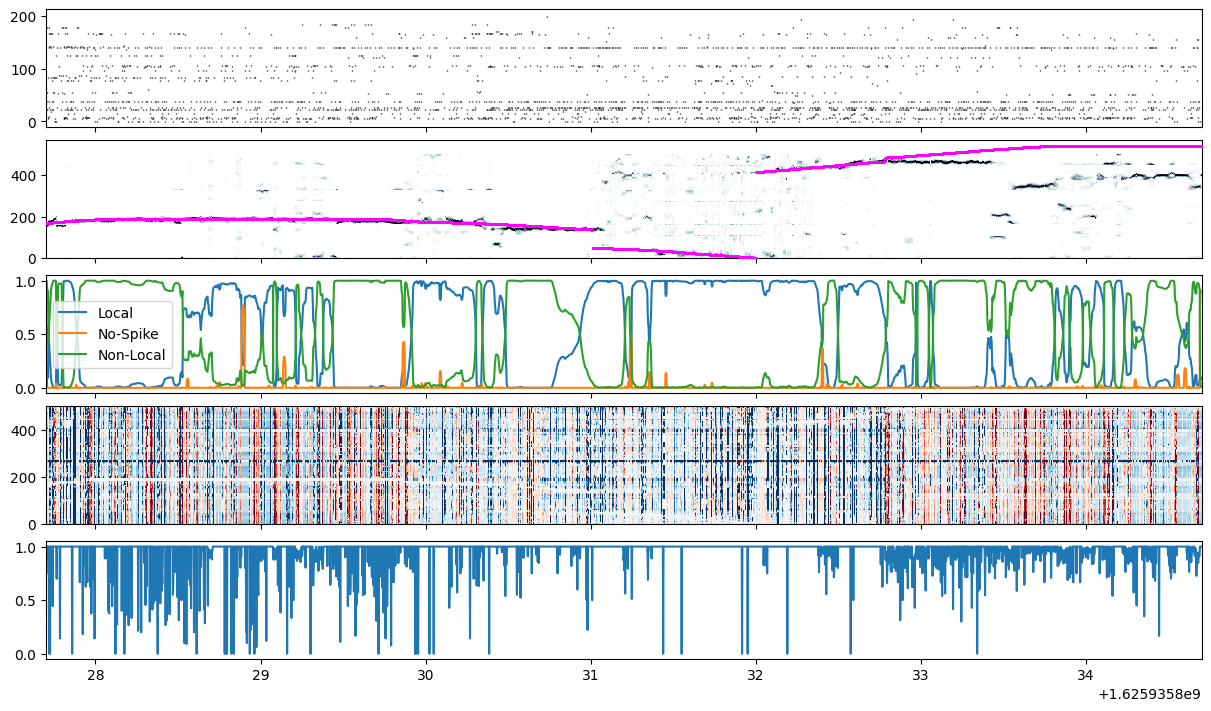

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(12, 7), sharex=True, constrained_layout=True)

time_slice = slice(time[0] + 70.0, time[0] + 77.0)
is_time_slice = (time >= time_slice.start) & (time <= time_slice.stop)

t, x = np.meshgrid(time[is_time_slice], env.place_bin_centers_)
conditional_non_local_acausal_posterior = acausal_posterior[is_time_slice, 2:]
conditional_non_local_acausal_posterior /= np.nansum(
    conditional_non_local_acausal_posterior, axis=1
)[:, np.newaxis]

axes[0].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times >= time_slice.start)
            & (neuron_spike_times <= time_slice.stop)
        ]
        for neuron_spike_times in spike_times
    ],
    colors="k",
    linewidths=1,
    rasterized=True,
)
axes[1].pcolormesh(
    t,
    x,
    conditional_non_local_acausal_posterior.T,
    vmin=0.0,
    vmax=0.1,
    rasterized=True,
    cmap="bone_r",
)
axes[1].scatter(
    time[is_time_slice],
    position[is_time_slice],
    s=1,
    color="magenta",
    rasterized=True,
    zorder=10,
)
axes[2].plot(
    time[is_time_slice], acausal_state_probabilities[is_time_slice, 0], label="Local"
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities[is_time_slice, 1],
    label="No-Spike",
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities[is_time_slice, 2],
    label="Non-Local",
)
axes[2].legend()


axes[3].pcolormesh(
    t,
    x,
    (
        log_likelihood[is_time_slice, 2:]
        - log_likelihood[is_time_slice, 0][:, np.newaxis]
    ).T,
    cmap="RdBu_r",
    rasterized=True,
    vmin=-3,
    vmax=3,
)
axes[4].plot(time[is_time_slice], hpd_overlap[is_time_slice])

plt.xlim((time_slice.start, time_slice.stop))


(1625935797.7008803, 1625935817.7008803)

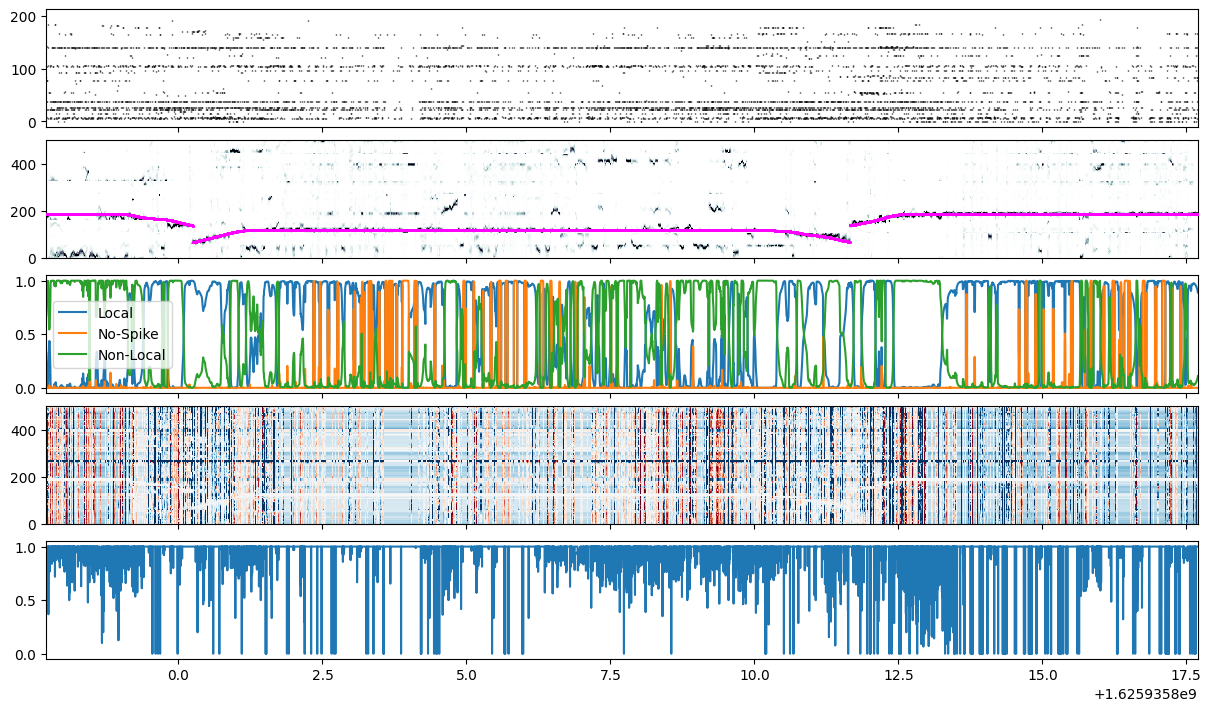

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(12, 7), sharex=True, constrained_layout=True)

time_slice = slice(time[0] + 40.0, time[0] + 60.0)
is_time_slice = (time >= time_slice.start) & (time <= time_slice.stop)

t, x = np.meshgrid(time[is_time_slice], env.place_bin_centers_)
conditional_non_local_acausal_posterior = acausal_posterior[is_time_slice, 2:]
conditional_non_local_acausal_posterior /= np.nansum(
    conditional_non_local_acausal_posterior, axis=1
)[:, np.newaxis]

axes[0].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times >= time_slice.start)
            & (neuron_spike_times <= time_slice.stop)
        ]
        for neuron_spike_times in spike_times
    ],
    colors="k",
    linewidths=1,
    rasterized=True,
)
axes[1].pcolormesh(
    t,
    x,
    conditional_non_local_acausal_posterior.T,
    vmin=0.0,
    vmax=0.1,
    rasterized=True,
    cmap="bone_r",
)
axes[1].scatter(
    time[is_time_slice],
    position[is_time_slice],
    s=1,
    color="magenta",
    rasterized=True,
    zorder=10,
)
axes[2].plot(
    time[is_time_slice], acausal_state_probabilities[is_time_slice, 0], label="Local"
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities[is_time_slice, 1],
    label="No-Spike",
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities[is_time_slice, 2],
    label="Non-Local",
)
axes[2].legend()


axes[3].pcolormesh(
    t,
    x,
    (
        log_likelihood[is_time_slice, 2:]
        - log_likelihood[is_time_slice, 0][:, np.newaxis]
    ).T,
    cmap="RdBu_r",
    rasterized=True,
    vmin=-3,
    vmax=3,
)
axes[4].plot(time[is_time_slice], hpd_overlap[is_time_slice])

plt.xlim((time_slice.start, time_slice.stop))

(1625935811.2008803, 1625935811.5008802)

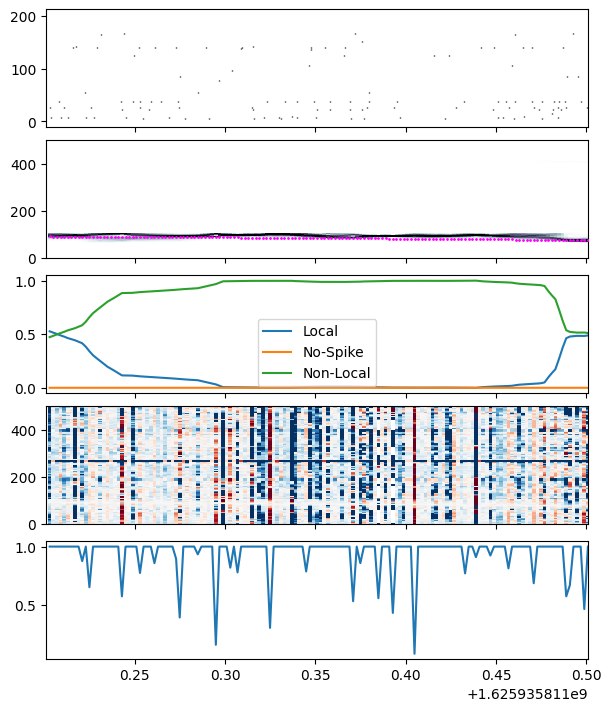

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(6, 7), sharex=True, constrained_layout=True)

time_slice = slice(time[0] + 53.5, time[0] + 53.8)
is_time_slice = (time >= time_slice.start) & (time <= time_slice.stop)

t, x = np.meshgrid(time[is_time_slice], env.place_bin_centers_)
conditional_non_local_acausal_posterior = acausal_posterior[is_time_slice, 2:]
conditional_non_local_acausal_posterior /= np.nansum(
    conditional_non_local_acausal_posterior, axis=1
)[:, np.newaxis]

axes[0].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times >= time_slice.start)
            & (neuron_spike_times <= time_slice.stop)
        ]
        for neuron_spike_times in spike_times
    ],
    colors="k",
    linewidths=1,
    rasterized=True,
)
axes[1].pcolormesh(
    t,
    x,
    conditional_non_local_acausal_posterior.T,
    vmin=0.0,
    vmax=0.1,
    rasterized=True,
    cmap="bone_r",
)
axes[1].scatter(
    time[is_time_slice],
    position[is_time_slice],
    s=1,
    color="magenta",
    rasterized=True,
    zorder=10,
)
axes[2].plot(
    time[is_time_slice], acausal_state_probabilities[is_time_slice, 0], label="Local"
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities[is_time_slice, 1],
    label="No-Spike",
)
axes[2].plot(
    time[is_time_slice],
    acausal_state_probabilities[is_time_slice, 2],
    label="Non-Local",
)
axes[2].legend()


axes[3].pcolormesh(
    t,
    x,
    (
        log_likelihood[is_time_slice, 2:]
        - log_likelihood[is_time_slice, 0][:, np.newaxis]
    ).T,
    cmap="RdBu_r",
    rasterized=True,
    vmin=-3,
    vmax=3,
)
axes[4].plot(time[is_time_slice], hpd_overlap[is_time_slice])

plt.xlim((time_slice.start, time_slice.stop))